# Kickstarter Projects
This is a Notebook to work the kickstarter_projects kaggle dataset. We're about to see how bla bla...

database link: https://www.kaggle.com/datasets/kemical/kickstarter-projects

atributs : ID ,name ,category ,main_category ,currency ,deadline ,goal ,launched ,pledged ,state ,backers ,country ,usd pledged

In [169]:
# Imports
import numpy as np
import pandas as pd
import datetime as dt
import time
import seaborn as sns
import sklearn
import category_encoders as ce
import matplotlib.pyplot as plt

Usaremos el segundo dataset puesto que ambos tienen algunos atributos diferentes, ambos tienen instancias en común costosas de filtrar, ambos tienen más de 300000 instancias (información más que suficiente) y el segundo tiene los atributos monetarios ya convertidos a USD

In [170]:
#Load datasets
#df1 = pd.read_csv('./datasets/ks-projects-201612.csv', encoding = 'utf-8', encoding_errors = 'replace')
#df2 = pd.read_csv('./datasets/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')

df = pd.read_csv('./datasets/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')

In [171]:
# Podemos ver atributos que no nos dicen nada como ID, name, usd_pledged (usd_pledged_real millor)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [172]:
df = df.drop(columns=['ID', 'name', 'usd pledged', 'pledged', 'goal'])
print(df.isnull().sum(axis = 0))
print((df == '?').sum(axis=0))

category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64
category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64


Hemos tenido mucha suerte al no tener NaNs

In [173]:
# definimos nuevos atributos
df['elapsed_days'] = (pd.to_datetime(df['deadline'])-pd.to_datetime(df['launched'])).dt.total_seconds()/(3600*24)
df['pledged/backer'] = df['usd_pledged_real']/df['backers']
df['pledged/backer'].fillna(value = 0, inplace=True)

col_list = list(df.columns)
x, y = col_list.index(df.columns[-1]), col_list.index('state')
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

In [174]:
aux = df['state'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
#should we drop live all except failed and successful?
print((auxn[1] + auxn[3])/auxn.sum())

['canceled' 'failed' 'live' 'successful' 'suspended' 'undefined']
[ 38779 197719   2799 133956   1846   3562]
0.8759153966212523


In [175]:
# nos quedamos solo con los registros fallidos o logrados (~88%)
df = df[np.logical_or(df['state'] == 'failed',df['state'] == 'successful')]
df.loc[df["state"] == "failed", "state"] = 0
df.loc[df["state"] == "successful", "state"] = 1

In [176]:
#23 paises distintos
aux = df['country'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['AT' 'AU' 'BE' 'CA' 'CH' 'DE' 'DK' 'ES' 'FR' 'GB' 'HK' 'IE' 'IT' 'JP'
 'LU' 'MX' 'N,0"' 'NL' 'NO' 'NZ' 'SE' 'SG' 'US']
[   485   6616    523  12370    652   3436    926   1873   2520  29454
    477    683   2369     23     57   1411    210   2411    582   1274
   1509    454 261360]
(23,)


In [177]:
#15 categorias principales
aux = df['main_category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['Art' 'Comics' 'Crafts' 'Dance' 'Design' 'Fashion' 'Film & Video' 'Food'
 'Games' 'Journalism' 'Music' 'Photography' 'Publishing' 'Technology'
 'Theater']
[25641  9878  7818  3573 25364 19775 56527 22054 28521  4149 45949  9689
 35445 27050 10242]
(15,)


In [178]:
#159 categorias
aux = df['category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['3D Printing' 'Academic' 'Accessories' 'Action' 'Animals' 'Animation'
 'Anthologies' 'Apparel' 'Apps' 'Architecture' 'Art' 'Art Books' 'Audio'
 'Bacon' 'Blues' 'Calendars' 'Camera Equipment' 'Candles' 'Ceramics'
 "Children's Books" 'Childrenswear' 'Chiptune' 'Civic Design'
 'Classical Music' 'Comedy' 'Comic Books' 'Comics' 'Community Gardens'
 'Conceptual Art' 'Cookbooks' 'Country & Folk' 'Couture' 'Crafts'
 'Crochet' 'DIY' 'DIY Electronics' 'Dance' 'Design' 'Digital Art'
 'Documentary' 'Drama' 'Drinks' 'Electronic Music' 'Embroidery' 'Events'
 'Experimental' 'Fabrication Tools' 'Faith' 'Family' 'Fantasy'
 "Farmer's Markets" 'Farms' 'Fashion' 'Festivals' 'Fiction' 'Film & Video'
 'Fine Art' 'Flight' 'Food' 'Food Trucks' 'Footwear' 'Gadgets' 'Games'
 'Gaming Hardware' 'Glass' 'Graphic Design' 'Graphic Novels' 'Hardware'
 'Hip-Hop' 'Horror' 'Illustration' 'Immersive' 'Indie Rock'
 'Installations' 'Interactive Design' 'Jazz' 'Jewelry' 'Journalism' 'Kids'
 'Knitting' 'Latin' 'Letterpress'

In [179]:
df.columns

Index(['category', 'main_category', 'currency', 'deadline', 'launched',
       'pledged/backer', 'backers', 'country', 'usd_pledged_real',
       'usd_goal_real', 'elapsed_days', 'state'],
      dtype='object')

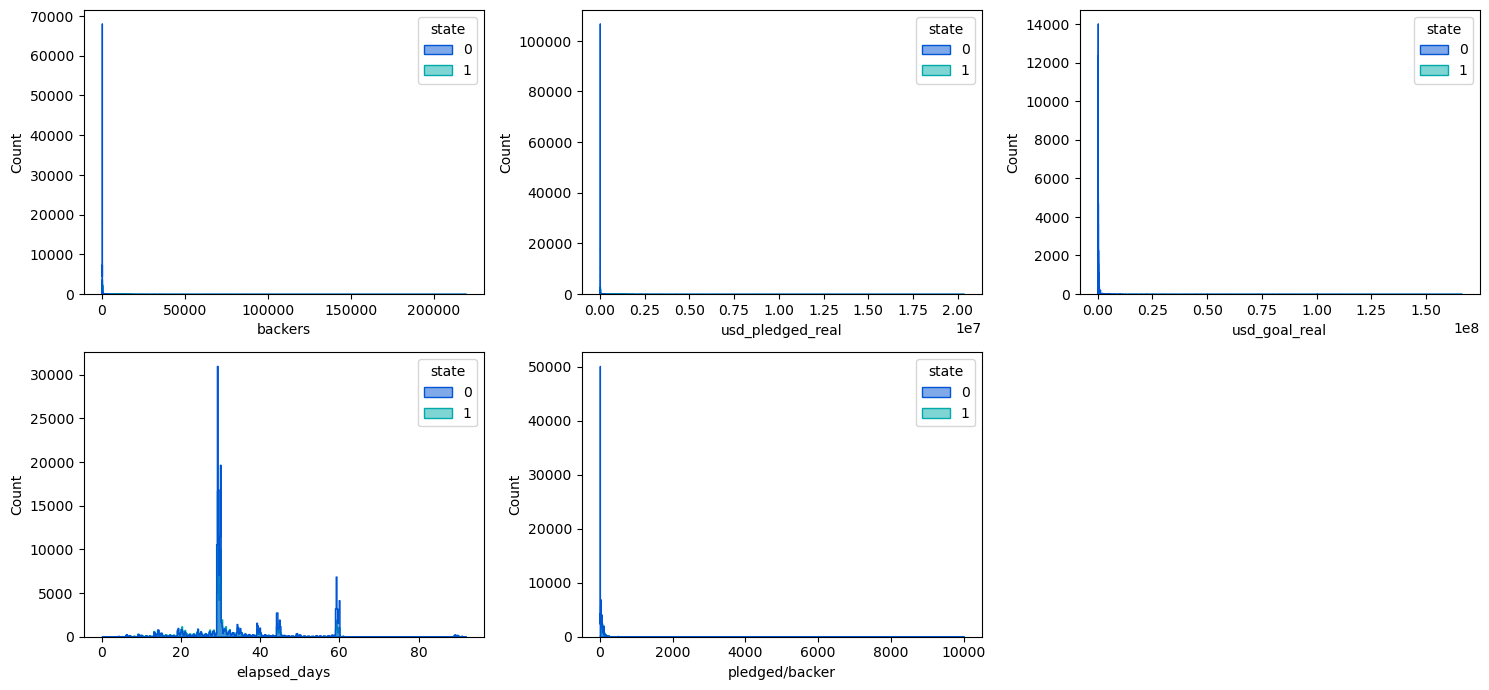

In [180]:
# distribució dels atributs segons els dos valors de la potabilitat
plt.figure(figsize = (15,10), tight_layout = True)

for i, feature in enumerate(['backers', 'usd_pledged_real', 'usd_goal_real',
       'elapsed_days', 'pledged/backer']):
    if feature != 'state':

        plt.subplot(3,3,i+1)
        sns.histplot(data = df, x =feature, palette='winter', hue = 'state',alpha = 0.5, element="step" )

In [181]:
df.dtypes

category             object
main_category        object
currency             object
deadline             object
launched             object
pledged/backer      float64
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
elapsed_days        float64
state                object
dtype: object

<AxesSubplot:>

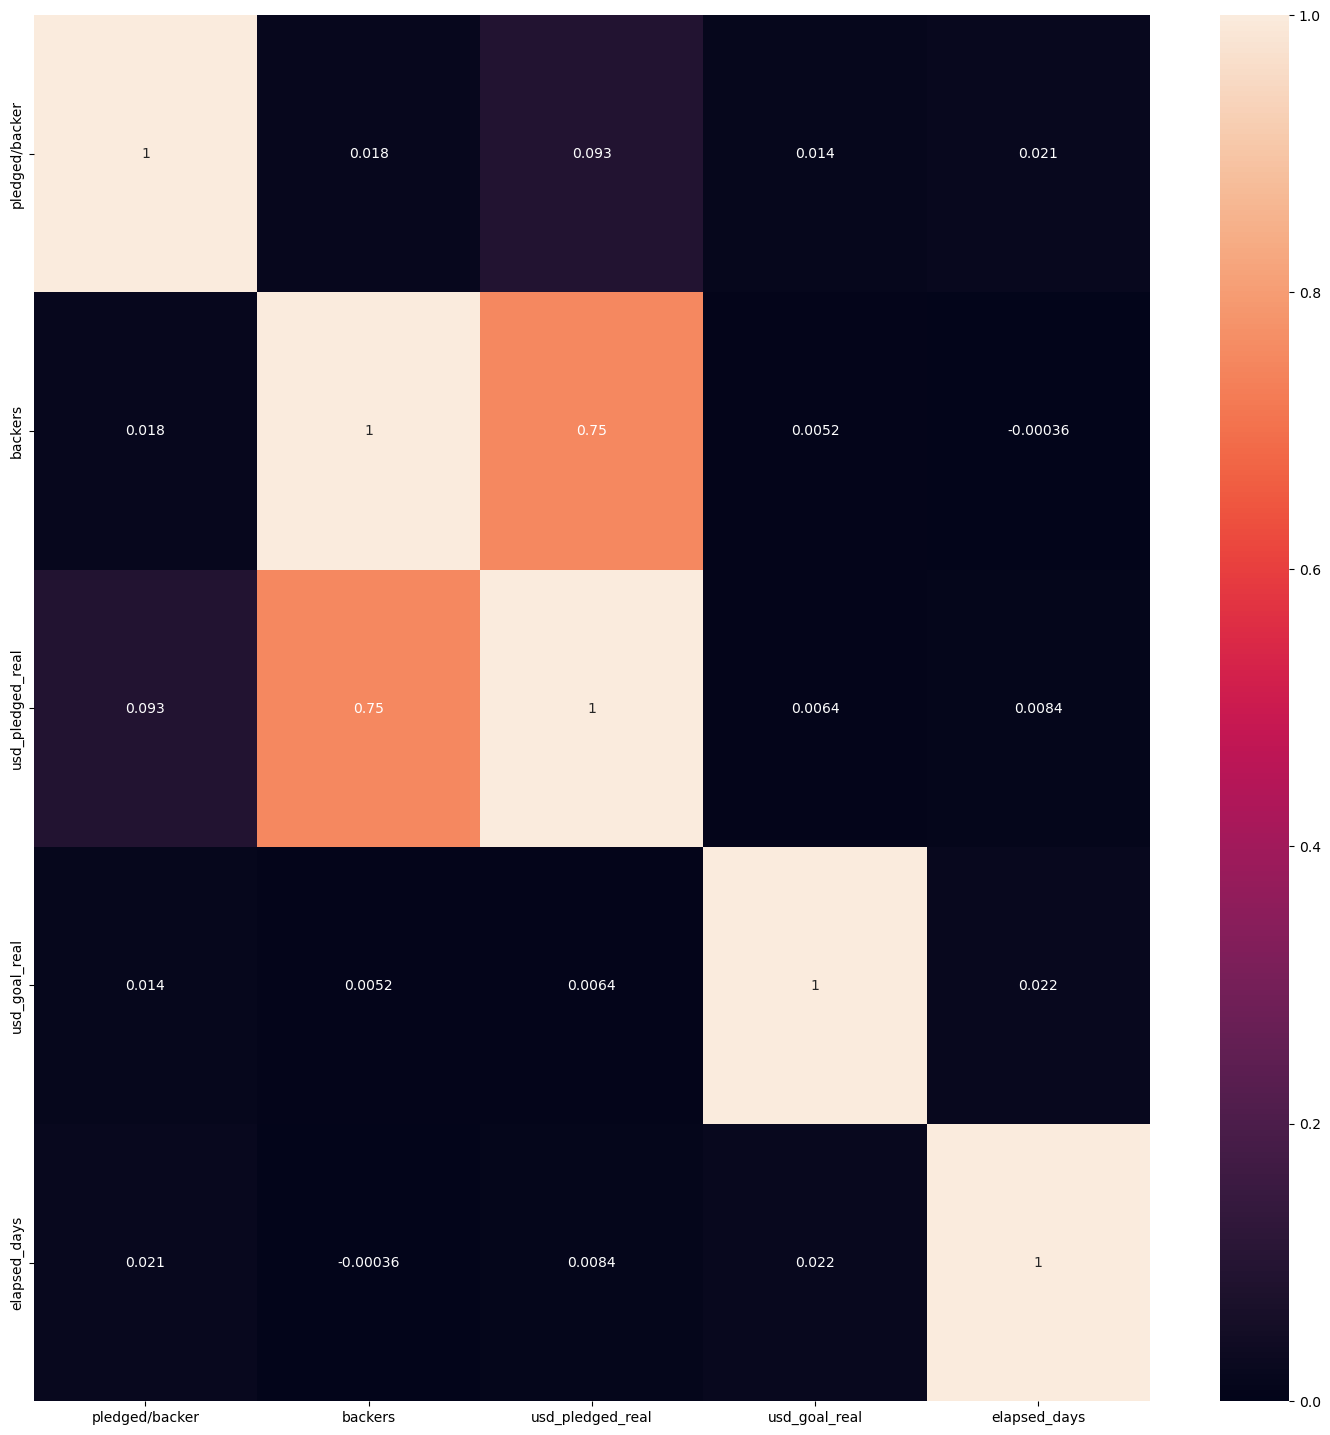

In [182]:
fig, ax = plt.subplots(figsize = (18,18))
sns.heatmap(df.corr(), ax = ax, annot = True)

In [183]:
df

,category,main_category,currency,deadline,launched,pledged/backer,backers,country,usd_pledged_real,usd_goal_real,elapsed_days,state
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,0.000000,0,GB,0.0,1533.95,58.491343,0
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,161.400000,15,US,2421.0,30000.00,59.802813,0
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,73.333333,3,US,220.0,45000.00,44.985532,0
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,1.000000,1,US,1.0,5000.00,29.858206,0
5,Restaurants,Food,USD,2016-04-01,2016-02-26 13:38:27,233.816964,224,US,52375.0,50000.00,34.431632,1
...,...,...,...,...,...,...,...,...,...,...,...,...
378654,Small Batch,Food,USD,2017-04-19,2017-03-20 22:08:22,38.500000,4,US,154.0,6500.00,29.077523,0
378657,Narrative Film,Film & Video,USD,2011-07-19,2011-06-22 03:35:14,31.000000,5,US,155.0,1500.00,26.850532,0
378658,Narrative Film,Film & Video,USD,2010-08-16,2010-07-01 19:40:30,20.000000,1,US,20.0,15000.00,45.180208,0
378659,Technology,Technology,USD,2016-02-13,2016-01-13 18:13:53,33.333333,6,US,200.0,15000.00,30.240359,0


In [66]:
ce_OHE = ce.OneHotEncoder(cols=['currency','category'])

data1 = ce_OHE.fit_transform(df)
data1

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,currency_14,deadline,goal,launched,state,backers,country,usd_pledged_real,usd_goal_real,elapsed_days
0,1,0,0,0,0,0,0,0,0,0,...,0,2015-10-09,1000.0,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58.491343
1,0,1,0,0,0,0,0,0,0,0,...,0,2017-11-01,30000.0,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59.802813
2,0,1,0,0,0,0,0,0,0,0,...,0,2013-02-26,45000.0,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44.985532
3,0,0,1,0,0,0,0,0,0,0,...,0,2012-04-16,5000.0,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29.858206
5,0,0,0,1,0,0,0,0,0,0,...,0,2016-04-01,50000.0,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,34.431632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,0,0,0,0,0,0,0,0,0,0,...,0,2017-04-19,6500.0,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,29.077523
378657,0,1,0,0,0,0,0,0,0,0,...,0,2011-07-19,1500.0,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,26.850532
378658,0,1,0,0,0,0,0,0,0,0,...,0,2010-08-16,15000.0,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,45.180208
378659,0,0,0,0,0,0,0,0,0,0,...,0,2016-02-13,15000.0,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,30.240359


In [69]:
ce_be = ce.BinaryEncoder(cols=['category']);

# transform the data
data_binary = ce_be.fit_transform(df);
data_binary

,category_0,category_1,category_2,category_3,category_4,category_5,category_6,category_7,main_category,currency,deadline,goal,launched,state,backers,country,usd_pledged_real,usd_goal_real,elapsed_days
0,0,0,0,0,0,0,0,1,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58.491343
1,0,0,0,0,0,0,1,0,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59.802813
2,0,0,0,0,0,0,1,0,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44.985532
3,0,0,0,0,0,0,1,1,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29.858206
5,0,0,0,0,0,1,0,0,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,34.431632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,0,1,1,1,1,0,0,1,Food,USD,2017-04-19,6500.0,2017-03-20 22:08:22,failed,4,US,154.0,6500.00,29.077523
378657,0,0,0,0,0,0,1,0,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,failed,5,US,155.0,1500.00,26.850532
378658,0,0,0,0,0,0,1,0,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,failed,1,US,20.0,15000.00,45.180208
378659,0,0,1,1,1,0,0,1,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,failed,6,US,200.0,15000.00,30.240359


In [150]:
X = df.values[:, :9]
y = df.values[:,9]

In [151]:
from sklearn.preprocessing import StandardScaler
# Standarize features
scaler = StandardScaler()

X = scaler.fit_transform(X)
x_t, x_v, y_t, y_v = train_test_split(X, y, test_size = 0.3, random_state = 42)

ValueError: could not convert string to float: 'Poetry'